In [1]:
import matplotlib.pyplot as plt

import numpy as np
import os
from ctd.comparison.analysis.tt.tt import Analysis_TT 
from ctd.comparison.analysis.dt.dt import Analysis_DT
# Import pca
import dotenv
from ctd.comparison.comparison import Comparison
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
dotenv.load_dotenv(dotenv.find_dotenv())

True

In [2]:
def plot_model_fps(fps, latents = None, q_thresh = 1e-5, label = "Model"):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    x_star = fps.xstar
    q_star = fps.qstar
    q_flag = q_star < q_thresh
    stability= fps.is_stable
    x_star = x_star[q_flag]
    q_star = q_star[q_flag]
    pca = PCA(n_components=3)
    if latents is not None:
        lats_flat = latents.reshape(-1, latents.shape[-1])
        lats_flat = pca.fit_transform(lats_flat)
        lats_pca = lats_flat.reshape(latents.shape[0], latents.shape[1], 3)
        x_star = pca.transform(x_star)
        for i in range(30):
            ax.plot(lats_pca[i,:,0], lats_pca[i,:,1], lats_pca[i,:,2], linewidth=0.5)
    else:
        x_star = pca.fit_transform(x_star)
    stability = stability[q_flag]
    stable_X = x_star[stability]
    unstable_X = x_star[~stability]
    ax.scatter(stable_X[:,0], stable_X[:,1], stable_X[:,2], c='g', marker='o', label = "Stable")
    ax.scatter(unstable_X[:,0], unstable_X[:,1], unstable_X[:,2], c='r', marker='x', label = "Unstable")
    ax.set_title(f"{label} FPS")
    ax.legend()
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.savefig(f"fps_{label}.pdf")

In [3]:


HOME_DIR = os.environ['HOME_DIR']
print(HOME_DIR)

pathTT = HOME_DIR + 'content/trained_models/task-trained/20240503_Fig1_NBFF_NoisyGRU/max_epochs=500 n_samples=1000 latent_size=64 seed=0 learning_rate=0.001/'
an_TT = Analysis_TT(run_name = "TT", filepath = pathTT)


path_GRU_Sweep = pathTT + "20240503_Fig1_NBFF_GRU_TT_GRU_Sweep/"
subfolders_GRU = [f.path for f in os.scandir(path_GRU_Sweep) if f.is_dir()]

path_LDS_Sweep = pathTT + "20240503_Fig1_NBFF_LDS_TT_GRU_Sweep/"
subfolders_LDS = [f.path for f in os.scandir(path_LDS_Sweep) if f.is_dir()]

path_NODE_Sweep = pathTT + "20240503_Fig1_NBFF_NODE_TT_GRU_Sweep/"
subfolders_NODE = [f.path for f in os.scandir(path_NODE_Sweep) if f.is_dir()]


/home/csverst/Github/CtDBenchmark/


In [4]:
comparison = Comparison(comparison_tag="Figure1NBFF_TTGRU_Sweep")
comparison.load_analysis(an_TT, reference_analysis=True, group = "TT")

for subfolder in subfolders_GRU:
    subfolder = subfolder + "/"
    analysis_GRU = Analysis_DT(run_name = "GRU", filepath = subfolder, model_type = "SAE")
    comparison.load_analysis(analysis_GRU, group = "GRU")

for subfolder in subfolders_LDS:
    subfolder = subfolder + "/"
    analysis_LDS = Analysis_DT(run_name = "LDS", filepath = subfolder, model_type = "SAE")
    comparison.load_analysis(analysis_LDS, group = "LDS")

for subfolder in subfolders_NODE:
    subfolder = subfolder + "/"
    analysis_NODE = Analysis_DT(run_name = "NODE", filepath = subfolder, model_type = "SAE")
    comparison.load_analysis(analysis_NODE, group = "NODE")


comparison.regroup()

In [5]:
# plot_dict = {
#     "save_pdf": True,
#     "ax_lim": [0.15, 1.05],
#     "marker": "o",
# }
# comparison.compare_rate_state_r2(plot_dict = plot_dict)

In [6]:
comparison_single = Comparison(comparison_tag="Figure1NBFF_TTGRU_DTNODE_Single")
comparison_single.load_analysis(an_TT, reference_analysis=True, group = "TT")
comparison_single.load_analysis(analysis_NODE, group = "NODE")
comparison_single.load_analysis(analysis_LDS, group = "LDS")
comparison_single.load_analysis(analysis_GRU, group = "GRU")
comparison_single.regroup()

#comparison_single.plot_trials_reference(num_trials =2, num_pcs=4)
# comparison_single.plot_trials_reference_dims(num_trials=2, dims = [0,1,2,3])


In [7]:

def visualize_stateR2(comp, num_trials=2, ref_ind = None, pcs_to_plot = [7,8,9,10,11]):
    self = comp
    if ref_ind is None:
        ref_ind = self.ref_ind
    if ref_ind is None and self.ref_ind is None:
        # Throw an error
        raise ValueError("No reference index provided")
    ref_lats = (
        self.analyses[ref_ind]
        .get_latents(
            phase="val",
        )
        .detach()
        .numpy()
    )
    pca = PCA()
    ref_lats_flat = ref_lats.reshape(
        ref_lats.shape[0] * ref_lats.shape[1], ref_lats.shape[2]
    )
    ref_lats_pca_flat = pca.fit_transform(ref_lats_flat)
    ref_lats_pca = ref_lats_pca_flat.reshape(ref_lats.shape)

    fig = plt.figure(figsize = (20,10))
    axes = fig.subplots(self.num_analyses, len(pcs_to_plot))
    for i in range(self.num_analyses):
        latents = self.analyses[i].get_latents(phase="val").detach().numpy()
        pca_DT = PCA()

        lats_flat = latents.reshape(
            latents.shape[0] * latents.shape[1], latents.shape[2]
        )
        lats_pca_flat = pca_DT.fit_transform(lats_flat)

        reg = LinearRegression().fit(ref_lats_pca_flat, lats_pca_flat)
        pred_latents_pca_flat = reg.predict(ref_lats_pca_flat)
        r2_scores = r2_score(lats_pca_flat, pred_latents_pca_flat, multioutput='raw_values')
        var_r2_score = r2_score(lats_pca_flat, pred_latents_pca_flat, multioutput='variance_weighted')
        print(f"R2 Score for {self.analyses[i].run_name}: {var_r2_score}")
        pred_latents_pca = pred_latents_pca_flat.reshape(latents.shape)
        lats_pca = lats_pca_flat.reshape(latents.shape)

        for j in range(len(pcs_to_plot)):
            pc_num = pcs_to_plot[j] + 1
            if pc_num < latents.shape[2]:
                axes[i, j].plot(pred_latents_pca[0, :100, pc_num], c = 'r', label="Predicted from TT")
                axes[i, j].plot(lats_pca[0, :100, pc_num], c = 'k', label = "True from DT")
                axes[i, j].text(75, .01, s= f"R2: {r2_scores[pc_num]:.2f}")
            else:
                axes[i, j].plot(np.zeros(lats_pca[0, :100, 0].shape), label = "Predicted from TT") 
            if i == self.num_analyses - 1:
                axes[i, j].set_xlabel("Time")
            else:
                axes[i, j].set_xticks([])

        axes[i, 0].set_ylabel(f"{self.analyses[i].run_name}")
    plt.savefig(f"state_r2_dims.pdf")

array([0.45369089, 0.30735934, 0.23894977, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

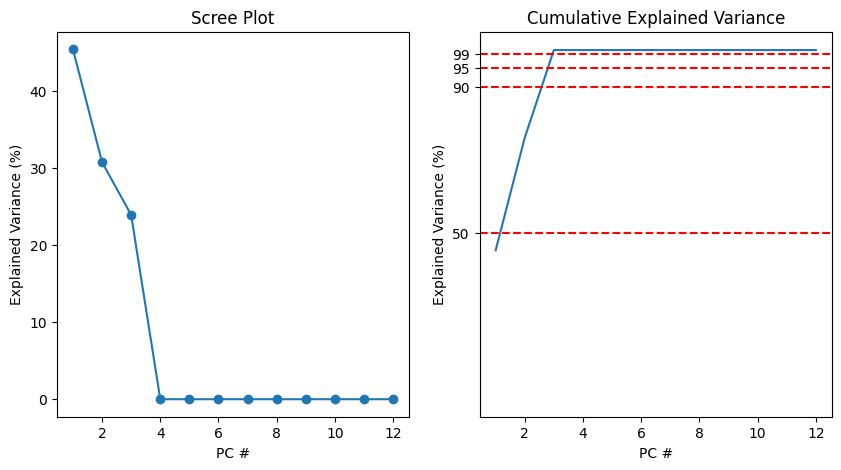

In [8]:
analysis_NODE.plot_scree(max_pcs = 12   )

array([0.25195843, 0.2145251 , 0.19593806, 0.02773466, 0.02470216,
       0.0241733 , 0.01223686, 0.01179639, 0.01067747, 0.008853  ,
       0.0081139 , 0.0079836 ])

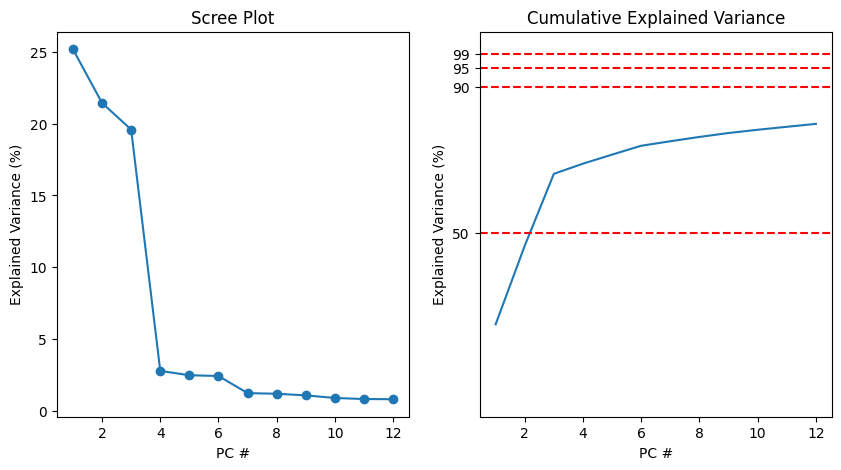

In [9]:
analysis_GRU.plot_scree(max_pcs = 12)

array([0.42637009, 0.26690848, 0.21592433, 0.03012053, 0.02164191,
       0.01624428, 0.00645672, 0.00464102, 0.00377866, 0.00254385,
       0.00155865, 0.00092647])

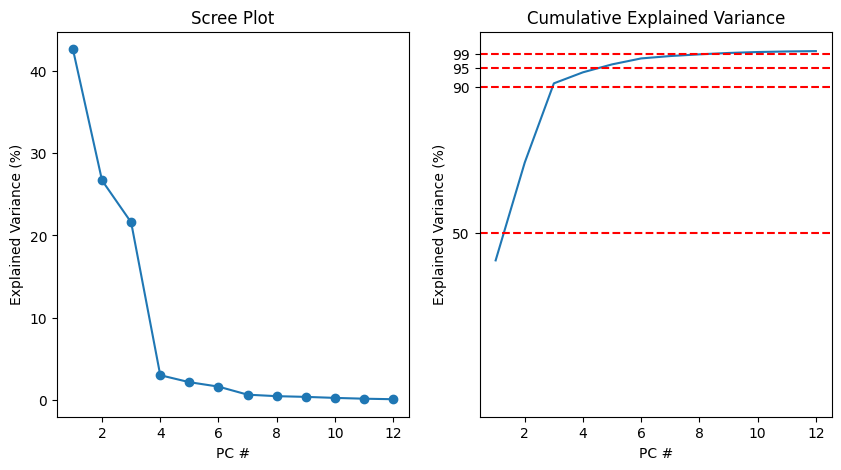

In [12]:
analysis_LDS.plot_scree(max_pcs = 12)

R2 Score for GRU: 0.852052024927344
R2 Score for LDS: 0.4463656524249299
R2 Score for NODE: 0.9666351528984644
R2 Score for TT: 0.989314001072645


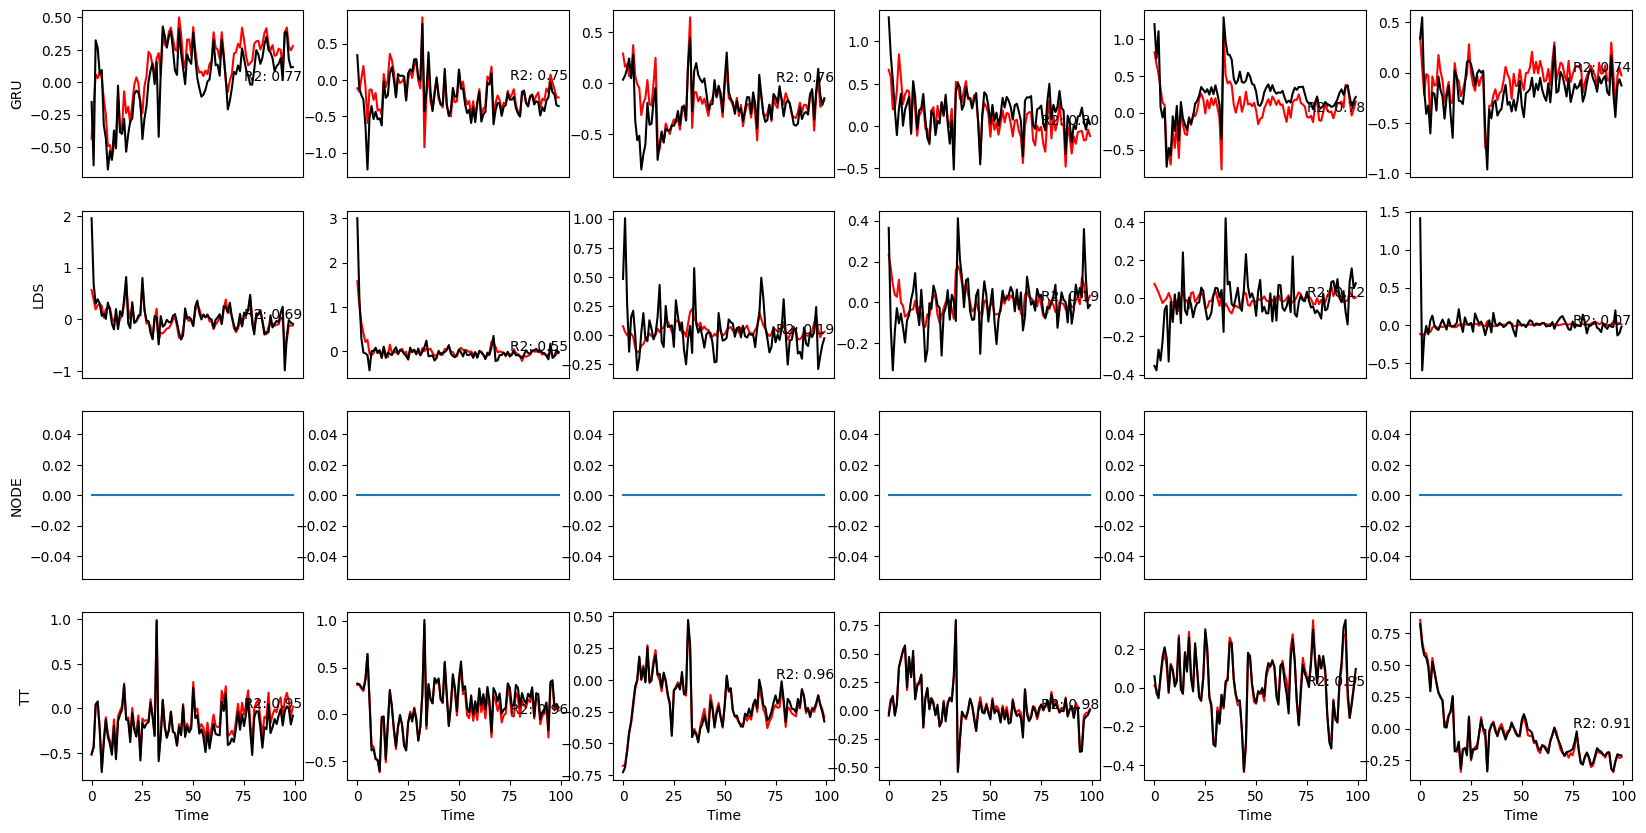

In [10]:

visualize_stateR2(comparison_single, pcs_to_plot=[7,8,9,10,11,12])

In [11]:
fpsTT = an_TT.plot_fps(
    inputs = torch.zeros(3),
    max_iters = 40000,
    learning_rate =5e-3,
)


Iteration 500/40000
q = 4.24E-04 +/- 1.70E-03
dq = 1.47E-06 +/- 6.32E-06

Iteration 1000/40000
q = 1.31E-04 +/- 5.15E-04
dq = 2.23E-07 +/- 9.22E-07

Iteration 1500/40000
q = 6.56E-05 +/- 2.49E-04
dq = 7.53E-08 +/- 3.17E-07

Iteration 2000/40000
q = 3.98E-05 +/- 1.40E-04
dq = 3.91E-08 +/- 1.52E-07

Iteration 2500/40000
q = 2.65E-05 +/- 8.58E-05
dq = 2.51E-08 +/- 8.21E-08

Iteration 3000/40000
q = 1.86E-05 +/- 5.59E-05
dq = 2.03E-08 +/- 5.74E-08

Iteration 3500/40000
q = 1.34E-05 +/- 3.82E-05
dq = 2.28E-08 +/- 6.06E-08

Iteration 4000/40000
q = 1.00E-05 +/- 2.71E-05
dq = 3.26E-08 +/- 9.21E-08


KeyboardInterrupt: 

In [ ]:
fpsDT_GRU = analysis_GRU.plot_fps(
    inputs = torch.zeros(3),
    max_iters = 40000,
    learning_rate =5e-3,
)

In [ ]:
fpsDT_NODE = analysis_NODE.plot_fps(
    inputs = torch.zeros(3),
    max_iters = 40000,
    learning_rate =5e-3,
)

In [ ]:
fpsDT_LDS = analysis_LDS.plot_fps(
    inputs = torch.zeros(3),
    max_iters = 40000,
    learning_rate =5e-3,
)

In [ ]:
lats_TT = an_TT.get_latents().detach().numpy()
lats_GRU = analysis_GRU.get_latents().detach().numpy()
lats_NODE = analysis_NODE.get_latents().detach().numpy()
lats_LDS = analysis_LDS.get_latents().detach().numpy()

plot_model_fps(fpsTT, latents=lats_TT, q_thresh = 1e-7, label = "TT")
plot_model_fps(fpsDT_GRU, latents = lats_GRU, q_thresh = 1e-6, label = "DT_GRU")
plot_model_fps(fpsDT_NODE, latents = lats_NODE, q_thresh = 1e-7, label = "DT_NODE")
plot_model_fps(fpsDT_LDS, latents = lats_LDS, q_thresh = 1e-7, label = "DT_LDS")

In [ ]:

comparison_models = Comparison()
comparison_models.load_analysis(an_TT, reference_analysis=True, group = "TT")
comparison_models.load_analysis(analysis_GRU, group = "GRU")
comparison_models.load_analysis(analysis_NODE, group = "NODE")
comparison_models.load_analysis(analysis_LDS, group = "LDS")
comparison_models.regroup()

In [ ]:
comparison_models.plot_trials_reference(num_trials=2, num_pcs=4)

In [ ]:
lds_fps = analysis_LDS.plot_fps(
    inputs = torch.zeros(3),
    learning_rate = 1e-3,
    n_inits=1024,
    max_iters = 20000,                      
)



In [ ]:
node_fps = analysis_NODE.plot_fps(
    inputs = torch.zeros(3),
    learning_rate = 6e-4,
    n_inits=1024,
    max_iters = 50000,                      
)

In [ ]:
gru_fps = analysis_GRU.plot_fps(
    inputs = torch.zeros(3),
    learning_rate = 6e-4,
    n_inits=1024,
    max_iters = 50000,                      
)

In [ ]:
plot_model_fps(lds_fps, q_thresh = 1e-4)
plot_model_fps(node_fps, q_thresh = 1e-4)
plot_model_fps(gru_fps, q_thresh = 4e-7)